In [1]:
import sys
import seaborn
import os.path as path
from mpl_toolkits.mplot3d import Axes3D

ROOT_PATH = path.abspath(path.join(".."))
sys.path.insert(4, f"{ROOT_PATH}")

from src.utils import *
from src.models.models import *
from src.notebook_utils import *
from src.data.clean_data import *
from src.models.evaluate import *
from src.data.make_dataset import *
from src.data.data_loader import *

%matplotlib inline

pd.options.mode.chained_assignment = None

## Introduction

Mandarin Chinese is a tonal language; each tone used changes the meaning of a word. There are five tones in Mandarin Chinese native speaker can differentiate. The purpose of this project is to train a model to replicate this skill, separating audio files into tone classes.

Advancements in computer vision have led most sound recognition projects to visualise the data into a spectrogram. But a spectrogram alone may not be useful for this project. A Mel spectrogram is a combination of a spectrogram, visualising sound vibrations, and a Mel scale, transforming linear frequencies to represent sounds humans consider important. That means a Mel Spectrogram will be able to visualise sound vibrations and also represent human's limitation in detecting differences between higher sound frequencies. Using this data, the model can learn to detect differences in the tones similar to a native Chinese Speaker.

A text file, including the Chinese dictionary, is used to build a list of unique Chinese Characters. I then requested pronunciations of each character from  https://api.forvo.com/, made by many native speakers.  With a variety of words and speakers, the model can be applied better in a real-world application, rather than using speech synthesis.

The downside of using pronunciation from real people is that it leads to more human error. To clean the data  I removed excess silence, computed the PCA to remove outliers and used Speach Recognition to detect low-quality data. I sampled data with a representative tone class distribution to remove any added bias. There is tradeoff using this method; although the quality of the data improved, this method removes a huge portion of the original dataset.

To make up for the loss during the data cleaning process, augmenting the data can artificially build enough samples for this project. Through manipulating the frequencies, noise injection or shifting the sound, I can create four times more of the original dataset. Increasing the size of the dataset lowers the risk of the model overfitting.

To finalise the data I converted the audio files into Mel spectrograms, storing the pixels and the label into a NumPy array. Then I used a PyTorch DataLoader to convert the data into tensors. 

There are three models used in this project:
1. SimpleCNN: 2 convolutional layers
2. ComplexCNN: 5 convolutional layers
3. DeepCNN: 9 convolutional layers

Between the models, all performed well on the test set achieving above an 85% accuracy score. The results confirm the quality of the dataset is suitable for the task at hand. It seems the more layers used the better the model perfroms as the deepCNN performend the best out of the three.

## Request Data

Building a list of unique Chinese characters.

In [2]:
chinese_words = extract_words(print_total=True)

# Total words: 10320.


Word examples

In [3]:
chinese_words[:10]

['冠', '病', '毒', '状', '三', '合', '症', '体', '综', '胶']

These two functions request the pronunciations and then save them.
* limit: maximum times you can request the same word

Note: I can only make 500 requests per day through this website, so we slice 500 words each day from our word list randomly.

In [4]:
mp3_urls = request_pronunciations(chinese_words, API_KEY, limit=4)
audio_list = save_pronunciations(mp3_urls)

100%|██████████| 529/529 [05:37<00:00,  1.57it/s]


Building a DataFrame and also appending the previous appended dataset.

In [5]:
audio_data = build_dataframe(audio_list)

Appending Previous Data Set!


The data frame includes information about the audio file's tone, word, and Id.

In [6]:
audio_data.head()

duration                     id  labels nframes  tone word
0  2.246531  audio_3765d7a5-1a.wav     1.0   99072   2.0    苻
1  2.560000  audio_8447e768-54.wav     0.0  112896   1.0    玎
2  3.056327  audio_1433233e-9d.wav     3.0  134784   4.0    玥
3  2.351020  audio_82e6fc9e-bf.wav     0.0  103680   1.0    馐
4  2.533878  audio_10ab3d25-1d.wav     0.0  111744   1.0    馐

In [7]:
audio_data.to_pickle(f"{DATA_PATH}/processed/audio_df.pkl")

## Data Exploration


In [40]:
audio_data = pd.read_pickle(f"{DATA_PATH}/processed/Pickle/audio_df.pkl")

There are null values within the tone and label category, highlighting some error occurred extracting the tone.

In [41]:
audio_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 802 entries, 0 to 801
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   duration  802 non-null    float64
 1   id        802 non-null    object 
 2   labels    781 non-null    float64
 3   nframes   802 non-null    object 
 4   tone      781 non-null    float64
 5   word      802 non-null    object 
dtypes: float64(3), object(3)
memory usage: 43.9+ KB


###  Tones

* Tone 1: pronounced in a high pitch
* Tone 2: a low to high pitch sound
* Tone 3: pronounced in a deep pitch
* Tone 4: a high to low pitch sound

Here are few examples of each tone.


In [42]:
play_tones(audio_data)

This confirms the dataset's tone distribution is representative of the real world.

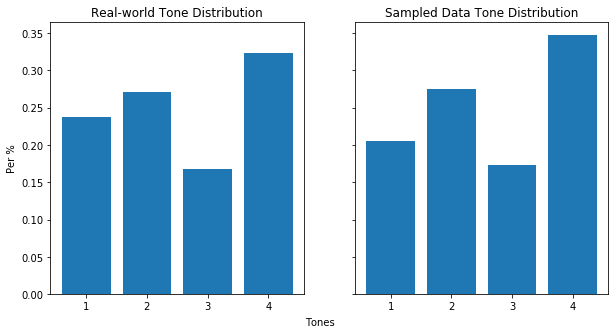

In [43]:
display_tone_distributions(chinese_words, audio_data)

There are few annomlies dected in the audio duration. 

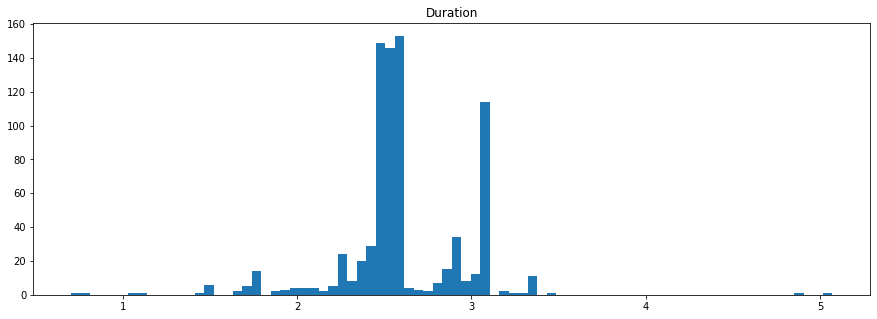

In [44]:
display_duration(audio_data)

The wave plots show that a huge portion of the audio files contain silence.

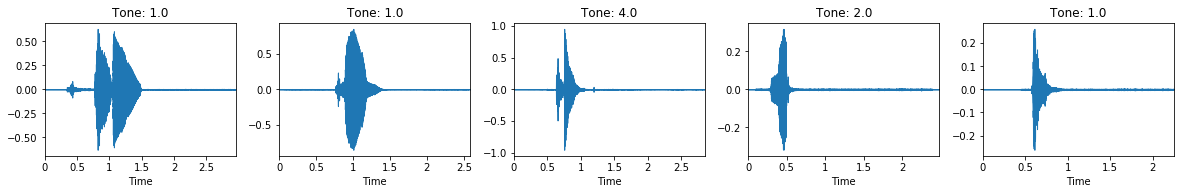

In [45]:
display_waveplots(audio_data)

The Mel spectrograms provide more information about the audio files but are not easy to interpret.

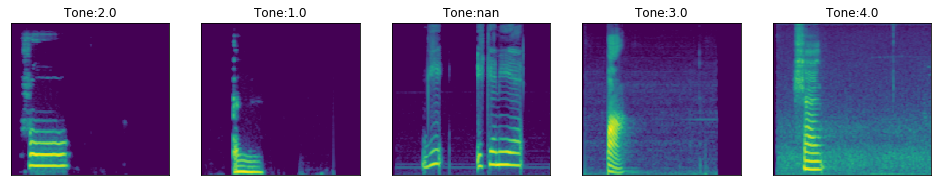

In [46]:
display_specgrams(audio_data)

## Remove Silence

The wave plots showed huge portions of the audio files contain silence. Removing the silence ensures most audio files have similar lengths to simplify the task for the model.  Removing silence can also identify some audio files that include too much Gaussian noise.

Remove all null values in the data.

In [47]:
audio_data = audio_data.dropna()

A function that removes the silence from the audio files.

In [48]:
audio_data = remove_silence(audio_data)

100%|██████████| 781/781 [00:05<00:00, 154.10it/s]


A comparison of the audio file with or without the silence removed.

In [49]:
play_audio_length(audio_data)

Word: 镀, Tone: 4.0


After removing the silence, the duration range has decreased and has more of a normal distribution. Outliers are still visible, audio files longer than 2 seconds.

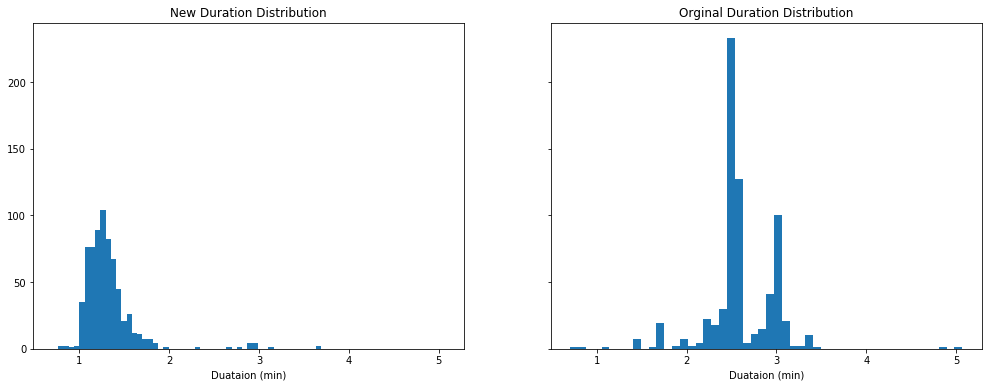

In [50]:
display_duration_comparison(audio_data)

Audio files longer than 2 seconds tend to include more Gaussian noise; silenced was not identified, so nothing was removed.

Here are two examples of the longer audio files.

In [51]:
play_long_audio(audio_data)

Removing audio files longer than 2 seconds.

In [52]:
audio_data = audio_data[audio_data['new_duration'] < 2]

## Data Augmentation

The data cleaning process removes nearly half of the audio files. The remaining data will not be enough to prevent the model from overfitting.  Augmenting can solve this issue.

I can produce four variations of the same audio file by manipulating the frequencies, noise injection or shifting the sound. 

Here are examples of different audio types.

In [53]:
play_aug(audio_data)

There are noticeable differences within each wave plot of the same file.

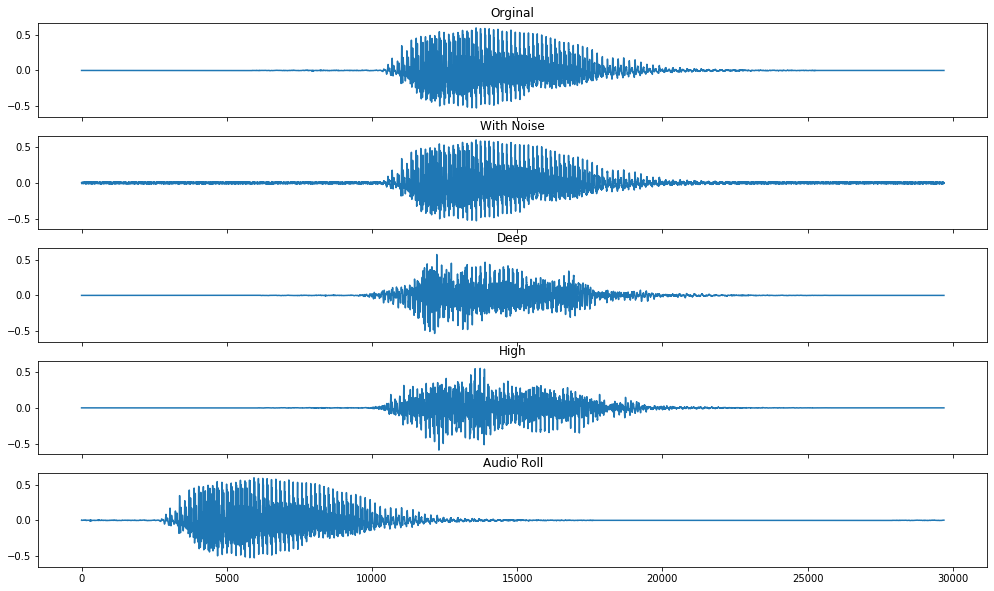

In [54]:
display_aug(audio_data)

Now there are enough samples to prevent overfitting occurring.

In [55]:
audio_data_ag = audio_augmentation(audio_data)                   

100%|██████████| 670/670 [00:04<00:00, 158.14it/s]

# Samples Added: 2680 


## PCA

Principle Component Analysis allows me to reduce the dimensions of the Mel Spectrograms, plot the residuals, and then identify any outliers or clusters within the data. Then an Isolation Forest is applied to determine whether or not an observation is an outlier.

A function that computes the PCA and the Isolation Forest.

In [56]:
audio_pca = pca_audio(audio_data_ag)
audio_pca = detect_outliers(audio_pca)
audio_pca.to_pickle(f"{DATA_PATH}/processed/Pickle/audio_pca.pkl")

100%|██████████| 3350/3350 [00:52<00:00, 63.22it/s] 


There are no visible tone clusters. Not enough data was retained during the PCA to represent the differences in tones.

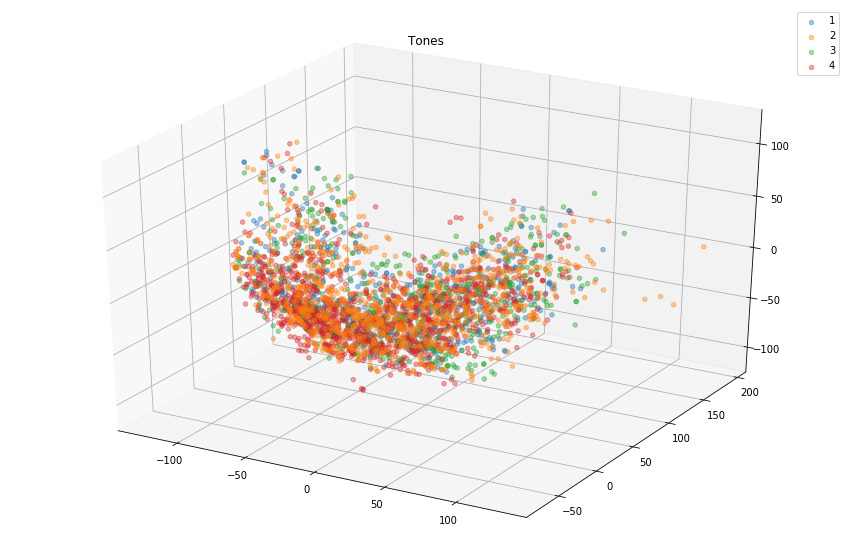

In [57]:
display_pca_tones(audio_pca)

There are visible audio type clusters, especially the audio with noise or the shifted audio.

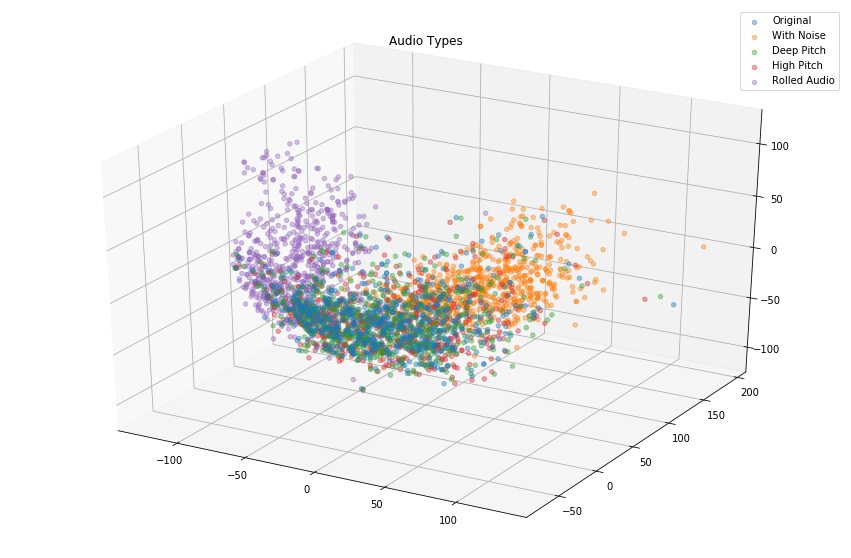

In [58]:
display_pca_types(audio_pca)

Audio data with noise or shifted audio are more likely to class as an outlier.

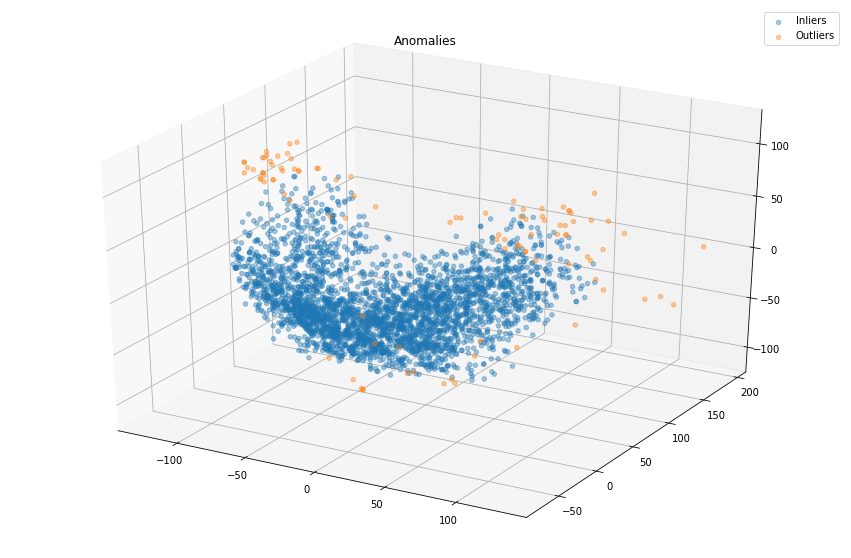

In [59]:
display_outliers(audio_pca)

Error is more common in the audio files labelled as outliers, but this is not always the case. There is not enough information retained during the PCA to make this strong assumption. 

In [60]:
play_anomalies(audio_pca)

Tone: 4.0	Anomaly: 1	Audio Type: RL


Tone: 2.0	Anomaly: -1	Audio Type: CL


I removed the outliers as they could affect model performance.

In [61]:
audio_inlier = audio_pca[audio_pca.anomaly == 1]

## Speech Recognition

Google Speech Recognition is used to assess the quality of the data, remove any inconsistent data and remove audio files that are related to their label.

To label the quality of the data,  I made assumptions based on the results of the transcription task:
* 0: if one of the transcripts match the word
* 1: if one of the transcript's tone matches the tone
* 2: if none of the transcripts matches the word or the tone


In [62]:
audio_cln = speech_recognition_assessment(audio_inlier)

100%|██████████| 3249/3249 [00:09<00:00, 342.15it/s]


The low-quality audio files are more likely not to match its label or lack clarity. Using this data will confuse our model as it won't be able to separate patterns in each class.

In [72]:
play_audio_quality(audio_cln)

Tone: 1.0	Sound Quality: 0.0	Audio Type: CL


Tone: 3.0	Sound Quality: 2.0	Audio Type: DP


I only select data that have sound quality 0 or 1, removing half of the augmented dataset. 

In [73]:
data_count = len(audio_inlier)
audio_best = audio_cln[audio_cln.sound_quality <= 1]
print(f'# Samples Removed: {data_count - len(audio_best)}')

# Samples Removed: 1485


## Sampling Data

Within this process, I plan on sampling data that will have a representative of the real-world tone distribution to remove bias.

The distribution of the tones in the dataset does not match the real world, indicating there is added bias. 

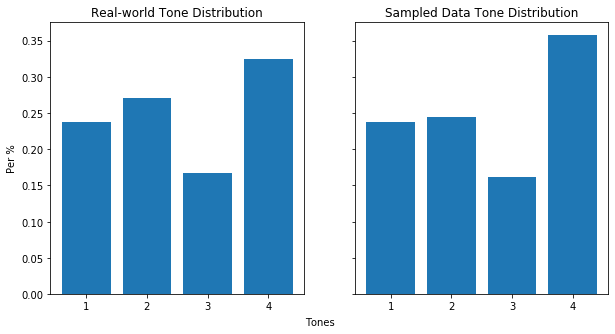

In [74]:
display_tone_distributions(chinese_words, audio_best, path='tone_distrib2.png')

A function that retrieves the real-world tone distribution as a pandas Series.

In [75]:
tone_per = get_tone_distrubtion(chinese_words)

This function samples the data to match the real-world tone distribution.

In [76]:
audio_pr = sample_tone_per(audio_best, tone_per)

# Samples Removed: 175 


Our sampled data tone distribution is now representative.

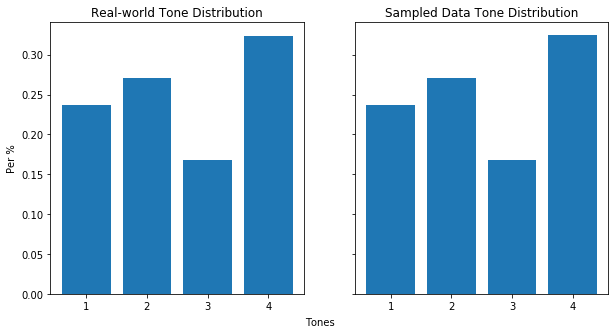

In [77]:
display_tone_distributions(chinese_words, audio_pr, path='tone_distrib3.png')

In [78]:
print(len(audio_pr))

1589


## Data Preperation

Splitting the data

In [79]:
train, valid, test = split_data(audio_pr, test_per=0.05, val_per=0.15)

# Train Size: 1272
# Valid Size: 238
# Test Size: 79


Here I convert the audio files into Mel spectrograms and then load them into PyTorch tensor. 

The duration indicates the length I will transform each audio file using padding, ensuring each spectrogram has the same dimensions. 

In [80]:
train_loader, valid_loader, test_loader = prepare_data(train, valid, test, duration=2)

100%|██████████| 79/79 [00:01<00:00, 73.27it/s]


## Train

There are three models of different complexities in this project. Comparing the results gives me a strong basis on ways to tune the model for optimum performance.

### Base Model

The simple CNN, used as the base model, is composed of two convolutional layers.

In [81]:
simpleCNN = SimpleCNN()
print(simpleCNN)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=78720, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
  (log_softmax): LogSoftmax()
)


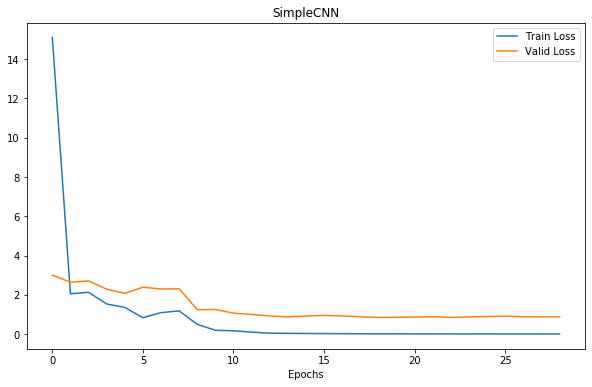

In [82]:
display_model_loss(simpleCNN)

### ComplexCNN

The complexCNN has five convolutional layers, uses batch normalisation to stabilise neurons and a drop out layer to reduce overfitting. 

In [83]:
complexCNN = ComplexCNN()
print(complexCNN)

ComplexCNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=115200, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
  (log_softmax): LogSoftmax()
)


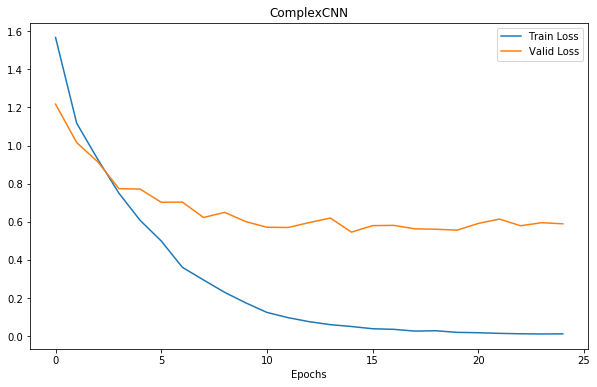

In [84]:
display_model_loss(complexCNN)

## DeepCNN


The is composed of nine convolutional layers, batch normalisation, and dropout.

In [85]:
deepCNN = DeepCNN()

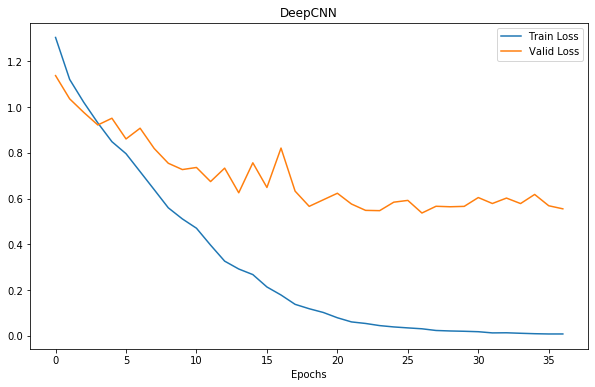

In [86]:
display_model_loss(deepCNN)

The complexCNN and deepCNN performed the best on the validation set.

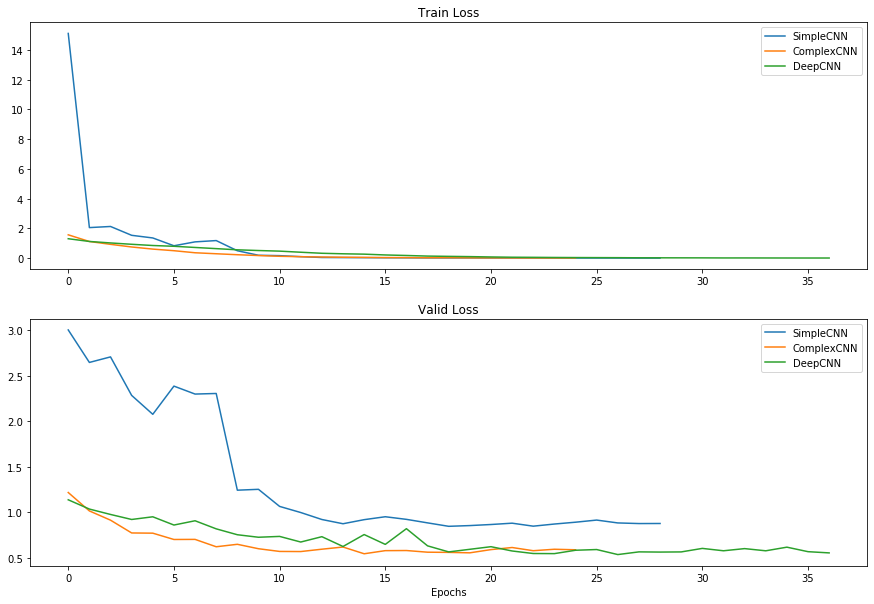

In [87]:
compare_model_loss(simpleCNN, complexCNN, deepCNN)

## Test Model

 The ComplexCNN perfomred the best on the test set

In [102]:
test_loader = load_object(f'{DATA_PATH}/interim/test_loader.pkl')

In [103]:
test_model(simpleCNN, test_loader)

100%|██████████| 5/5 [00:00<00:00, 11.54it/s]


{'SimpleCNN': 0.8607594936708861}

In [104]:
test_model(complexCNN, test_loader)

100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


{'ComplexCNN': 0.8734177215189873}

In [105]:
test_model(deepCNN, test_loader)

100%|██████████| 5/5 [00:00<00:00,  6.47it/s]


{'DeepCNN': 0.9113924050632911}

The ResNet outperformed the other two models

## Conclusion

Each process taken in the data wrangling process is what leads to the high-performing models.  Data augmentation reduces the risk of overfitting. Removing outliers and speech recognition assessment improves the quality of the data. Sampling a representative tone class distribution allows the model to perform better in the real world.

